In [ ]:
# Install main libraries
! pip install transformers -U
! pip install accelerate -U
! pip install datasets

In [ ]:
# Data manipulation
import pandas as pd
from datasets import Dataset, DatasetDict

# Miscellaneous
import numpy as np
import torch
import matplotlib.pyplot as plt
import json

# Models
from sklearn.dummy import DummyClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix
from transformers import EvalPrediction


##🎈Task 1 - Load dataset & Preprocessing

First, we load the tsv files into pandas dataframes.

In [ ]:
# Train
df_x_train = pd.read_csv('arguments-training.tsv', sep='\t')
df_y_train = pd.read_csv('labels-training.tsv', sep='\t')

# Validation
df_x_val = pd.read_csv('arguments-validation.tsv', sep='\t')
df_y_val = pd.read_csv('labels-validation.tsv', sep='\t')

# Test
df_x_test = pd.read_csv('arguments-test.tsv', sep='\t')
df_y_test = pd.read_csv('labels-test.tsv', sep='\t')


# Drop the Argument ID since we don't need it
del df_x_train['Argument ID']
del df_x_val['Argument ID']
del df_x_test['Argument ID']

df_x_train.head()

,Conclusion,Stance,Premise
0,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,We should ban factory farming,against,factory farming allows for the production of c...


Regarding the labels, we merge them together obtaining level 3 categories.

In [ ]:
# Train
openness_to_change = df_y_train.iloc[:, 1:5].any(axis=1)
self_enhancement = df_y_train.iloc[:, 4:9].any(axis=1)
conservation = df_y_train.iloc[:, 8:15].any(axis=1)
self_transcendence = df_y_train.iloc[:, 14:].any(axis=1)

super_df_y_train = pd.DataFrame({
    'openness_to_change': openness_to_change,
    'self_enhancement': self_enhancement,
    'conservation': conservation,
    'self_transcendence': self_transcendence
}, dtype=int)

# super_df_y_train
# 5393 rows x 4 columns

In [ ]:
# Validation
openness_to_change = df_y_val.iloc[:, 1:5].any(axis=1)
self_enhancement = df_y_val.iloc[:, 4:9].any(axis=1)
conservation = df_y_val.iloc[:, 8:15].any(axis=1)
self_transcendence = df_y_val.iloc[:, 14:].any(axis=1)

super_df_y_val = pd.DataFrame({
    'openness_to_change': openness_to_change,
    'self_enhancement': self_enhancement,
    'conservation': conservation,
    'self_transcendence': self_transcendence
}, dtype=int)

# super_df_y_val
# 1896 rows x 4 columns


In [ ]:
# Test
openness_to_change = df_y_test.iloc[:, 1:5].any(axis=1)
self_enhancement = df_y_test.iloc[:, 4:9].any(axis=1)
conservation = df_y_test.iloc[:, 8:15].any(axis=1)
self_transcendence = df_y_test.iloc[:, 14:].any(axis=1)

super_df_y_test = pd.DataFrame({
    'openness_to_change': openness_to_change,
    'self_enhancement': self_enhancement,
    'conservation': conservation,
    'self_transcendence': self_transcendence
}, dtype=int)

# super_df_y_test
# 1576 rows x 4 columns

We concatenate the sentences and the labels in a pandas dataframe. Then, we wrap the dataframes in datasets, and collect them in a dictionary.

In [ ]:
# Train
X_train = pd.concat([df_x_train, super_df_y_train], axis=1)

# Val
X_val = pd.concat([df_x_val, super_df_y_val], axis=1)

# Test
X_test = pd.concat([df_x_test, super_df_y_test], axis=1)

train_dataset = Dataset.from_pandas(X_train)
val_dataset = Dataset.from_pandas(X_val)
test_dataset = Dataset.from_pandas(X_test)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


Now out datasets contains three splits: train, validation, and test.

We create a mapping from ids to labels, since we will be using it during model definition.

In [ ]:
labels = ['openness_to_change', 'self_enhancement', 'conservation', 'self_transcendence']

id2label = { idx:cat for idx, cat in enumerate(labels)}
label2id = { cat:idx for idx, cat in enumerate(labels)}

label2id

{'openness_to_change': 0,
 'self_enhancement': 1,
 'conservation': 2,
 'self_transcendence': 3}

We inspect how many labels are set to 1 in each split and create an histogram.


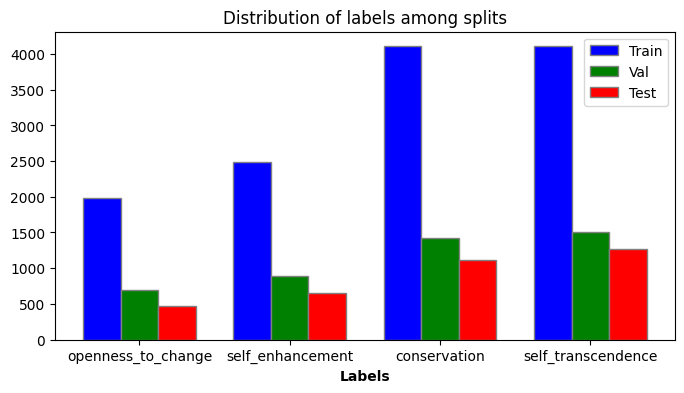

In [ ]:
# Train set
train_label_hist = []
for label in labels:
    train_label_hist.append(sum(dataset['train'][label]))

# Val set
val_label_hist = []
for label in labels:
    val_label_hist.append(sum(dataset['validation'][label]))

# Test set
test_label_hist = []
for label in labels:
    test_label_hist.append(sum(dataset['test'][label]))

# Plotting
plt.figure(figsize=[8,4])
bar_width = 0.25
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create grouped bar plot
plt.bar(r1, train_label_hist, color='b', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, val_label_hist, color='g', width=bar_width, edgecolor='grey', label='Val')
plt.bar(r3, test_label_hist, color='r', width=bar_width, edgecolor='grey', label='Test')

# Add x-axis labels and title
plt.xlabel('Labels', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.title('Distribution of labels among splits')
plt.legend()
plt.show()


We now inspect the length of each sentence - Conclusion and Premise. This will help us choosing the truncation number.

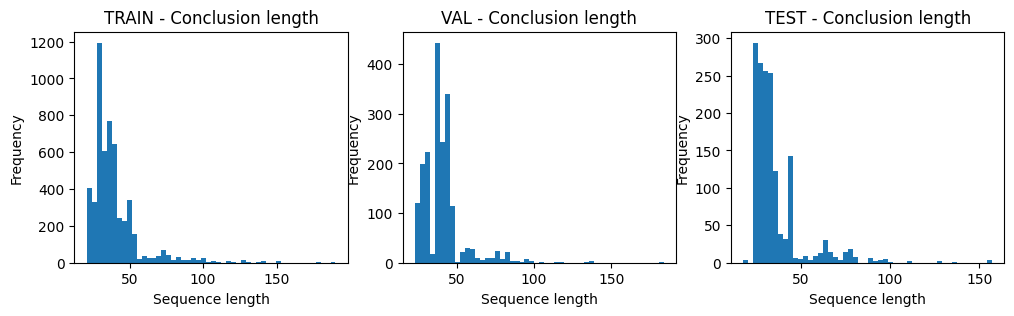

In [ ]:
# Inspecting the length of each conclusion sequence
conclusion_length_train = [len(seq) for seq in X_train['Conclusion']]
conclusion_length_val = [len(seq) for seq in X_val['Conclusion']]
conclusion_length_test = [len(seq) for seq in X_test['Conclusion']]

# Plot the histogram
plt.figure(figsize=[12,3])
plt.subplot(1,3,1)
plt.hist(conclusion_length_train, bins=50)
plt.title('TRAIN - Conclusion length')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(conclusion_length_val, bins=50)
plt.title('VAL - Conclusion length')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
plt.hist(conclusion_length_test, bins=50)
plt.title('TEST - Conclusion length')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.show()

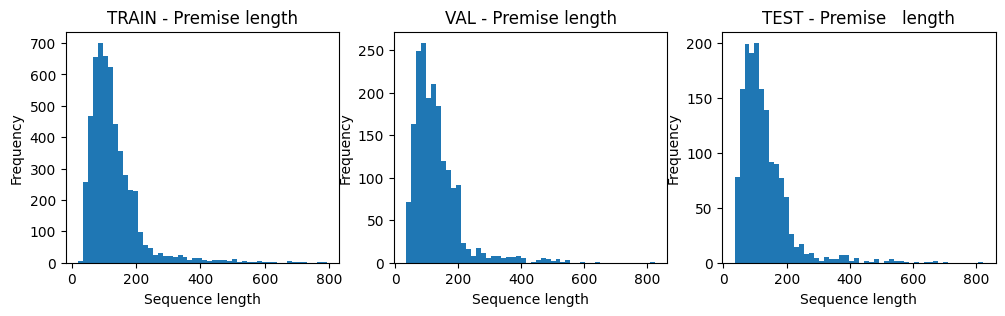

In [ ]:
# Inspecting the length of each premise sequence
premise_length_train = [len(seq) for seq in X_train['Premise']]
premise_length_val = [len(seq) for seq in X_val['Premise']]
premise_length_test = [len(seq) for seq in X_test['Premise']]

# Plot the histogram
plt.figure(figsize=[12,3])
plt.subplot(1,3,1)
plt.hist(premise_length_train, bins=50)
plt.title('TRAIN - Premise length')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(premise_length_val, bins=50)
plt.title('VAL - Premise length')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
plt.hist(premise_length_test, bins=50)
plt.title('TEST - Premise   length')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.show()

Preprocessing phase.

We use the AutoTokenizer API, which will load the appropriate tokenizer.

**Note 1**: we also need to provide labels to the model, a matrix of shape (batch_size, num_labels).

**Note 2**: Labels must be floats rather than integers, since we will be using `BCEWithLogitsLoss`.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def concat(sequence, tail=""):
    return sequence + " [SEP] " + tail

def preprocess_data(examples, mode=1):
  # take a batch of texts
  conclusion = examples["Conclusion"]
  premise = examples["Premise"]
  stance = examples["Stance"]

  # encode them
  if mode == 1:
      encoding = tokenizer(conclusion, padding="max_length", truncation=True, max_length=128)
  elif mode == 2:
      encoding = tokenizer(conclusion, premise, padding="max_length", truncation=True, max_length=256)
  elif mode == 3:
      premice_stance = [concat(seq, tail) for seq, tail in zip(premise, stance)]
      encoding = tokenizer(conclusion, premice_stance, padding="max_length", truncation=True, max_length=256)
  else:
      raise ValueError("Mode parameter must lay between 1 and 3")

  # add labels
  # for each label, we have the binary column for all the sentences in the batch
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}

  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(conclusion), len(labels)))

  # fill the labels_matrix
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  # append the list of the labels, eg. [1, 0, 0, 1], [0, 0, 1, 1], etc.
  encoding["labels"] = labels_matrix.tolist()

  return encoding


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
encoded_datasets = {}
db_names = ['db_conclusion', 'db_conclusion_premise', 'db_conclusion_premise_stance']

for i, key in enumerate(db_names):
    encoded_datasets[key] = dataset.map(lambda example: preprocess_data(example, mode=i+1),
                                      batched=True,
                                      remove_columns=dataset['train'].column_names)


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Let's retrieve an example and inpect the new column keys. Let's also decode a random example. Tipical form: [CLS], text, [SEP], [PAD] [PAD] [PAD] ...


In [ ]:
example = encoded_datasets['db_conclusion_premise_stance']['train'][3000]
example.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [ ]:
tokenizer.decode(example['input_ids'])


'[CLS] we should oppose collectivism [SEP] as individuals we have a right to not be grouped into one thought process. [SEP] in favor of [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
example['labels']


[1.0, 0.0, 0.0, 0.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]


['openness_to_change']

We also need to set the format of our data to PyTorch tensors.

In [ ]:
for db_name in db_names:
  encoded_datasets[db_name].set_format("torch")

This is how it looks the datasets once encoded. It is the format that expect our ML model.

In [ ]:
encoded_datasets['db_conclusion_premise_stance']['test']

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1576
})

##🎈Task 2 - Model definition

First we define and fit the 2 baselines. We save the trained classifiers into dictionaries, so then we can evaluate them on the validation.

In [ ]:
# We train individual random classifiers on each label
# We then collect the classifiers in a dictionary
uniform_classifiers = {}
majority_classifiers = {}

for label in labels:

    # Instanciate random and majority classifiers
    uni_classifier = DummyClassifier(strategy='uniform', random_state=42)
    maj_classifier = DummyClassifier(strategy='most_frequent', random_state=42)

    # Train the classifier on the training data
    # We fit it on the first 3 columns (Premise, Stance, Conclusion)
    uni_classifier.fit(X_train.iloc[:, :3], X_train[label])
    maj_classifier.fit(X_train.iloc[:, :3], X_train[label])

    # Save the trained classifier
    uniform_classifiers[label] = uni_classifier
    majority_classifiers[label] = maj_classifier


**Model 1: BERT w/C**. It includes a BERT-base pre-trained model, with a random initialized classification head (linear layer) on top. We will fine-tune this head on our labeled dataset.

The `problem_type` is "multi_label_classification", as we will be using `BCEWithLogitsLoss` loss function.

The output layer must also have `len(labels)` output neurons, and we set the id2label and label2id mappings.

In [ ]:
bert_c = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                            problem_type="multi_label_classification",
                                                            num_labels=len(labels),
                                                            id2label=id2label,
                                                            label2id=label2id)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Model 2**: BERT w/CP. This is the model trained with both the Conclusion and Premise.

In [ ]:
bert_cp = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                              problem_type="multi_label_classification",
                                                              num_labels=len(labels),
                                                              id2label=id2label,
                                                              label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Model 3**: BERT w/CPS: This is the model trained with Conclusion, Premise, and Stance.

In [ ]:
bert_cps = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                problem_type="multi_label_classification",
                                                                num_labels=len(labels),
                                                                id2label=id2label,
                                                                label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##🎈Task 3 - Metrics

We will define a `compute_metrics` functions that will compute metrics such as f1 macro, f1 score for each category, precision and recall.

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):

  # First, we convert logits to probabilities using the sigmoid function
  # prediction has shape (batch_size, num_labels)
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))

  # Next, we threshold to get integers
  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs >= threshold)] = 1

  # Finally, we compute the metrics
  y_true = labels

  f1_cat = f1_score(y_true = y_true, y_pred = y_pred, average = None)
  f1_macro = f1_score(y_true = y_true, y_pred = y_pred, average = 'macro')

  accuracy = accuracy_score(y_true, y_pred)

  # We pack the scores into a dictionary
  metrics = {'Openness_to_change_f1': f1_cat[0],
             'Self-enhancement_f1': f1_cat[1],
             'Conservation_f1': f1_cat[2],
             'Self-transcendence_f1': f1_cat[3],
             'f1': f1_macro,
             'accuracy': accuracy}
  return metrics

def compute_metrics(p: EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  result = multi_label_metrics(
      predictions = preds,
      labels = p.label_ids
  )
  return result


##🎈Task 4 - Training and evaluation

First, we set 3 seeds to have reproducible and more reliable results.

In [ ]:
# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)


In [ ]:
# Utility function that prints F1 scores based on seeds

def print_eval_history(eval_history):
    print('Macro F1')
    for seed in seeds:
        print(f"seed {seed}, score = {eval_history[seed]['eval_f1']:.3f}")
    print('-'*12)

    print('Openness to change F1')
    for seed in seeds:
        print(f"seed {seed}, score = {eval_history[seed]['eval_Openness_to_change_f1']:.3f}")
    print('-'*12)

    print('Self enhancement F1')
    for seed in seeds:
        print(f"seed {seed}, score = {eval_history[seed]['eval_Self-enhancement_f1']:.3f}")
    print('-'*12)

    print('Conservation F1')
    for seed in seeds:
        print(f"seed {seed}, score = {eval_history[seed]['eval_Conservation_f1']:.3f}")
    print('-'*12)

    print('Self transcendence F1')
    for seed in seeds:
        print(f"seed {seed}, score = {eval_history[seed]['eval_Self-transcendence_f1']:.3f}")
    print('-'*12)

We then train **BERT w/C model** using the HuggingFace's Trainer API 🤗. We need to define 2 things:
- **TrainingArguments**, that encapsulate the training hyperparaterms
- a **Trainer object**, that needs the model, arguments, datasets, tokenizer, and metrics

In [ ]:
#seeds = [42, 123, 456]
seeds = [456]
batch_size = 8
epochs = 3
metric_name = "f1"

In [ ]:
# BERT w/C
eval_history_bert_c = {}

for seed in seeds:

    # Setting the seed
    set_seed(seed)

    # Defining the training arguments
    args_bert_c = TrainingArguments(
        f"bert-finetuned-conclusion-{seed}",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate = 2e-5,
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size = batch_size,
        num_train_epochs = epochs,
        weight_decay = 0.01,
        load_best_model_at_end = True,
        metric_for_best_model = metric_name,
        seed = seed
    )

    # Defining the trainer object
    trainer_bert_c = Trainer(
        model = bert_c,
        args = args_bert_c,
        train_dataset = encoded_datasets['db_conclusion']['train'],
        eval_dataset = encoded_datasets['db_conclusion']['validation'],
        tokenizer = tokenizer,
        compute_metrics = compute_metrics
    )

    # Training
    trainer_bert_c.train()

    # Evaluating and saving history
    eval_history_bert_c[seed] = trainer_bert_c.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Openness To Change F1,Self-enhancement F1,Conservation F1,Self-transcendence F1,F1,Accuracy
1,0.584800,0.582724,0.319838,0.595152,0.858519,0.885362,0.664718,0.274262
2,0.553800,0.582480,0.398190,0.592365,0.858519,0.885362,0.683609,0.271097
3,0.537000,0.584697,0.363089,0.598291,0.859036,0.885362,0.676444,0.279008


In [ ]:
# Saving model weights

bert_c.save_pretrained("./bert_c_weights")
# bert_c = AutoModelForSequenceClassification.from_pretrained("./bert_c_weights")


In [ ]:
# Dumping the evaluation results

with open('eval_history_bert_c.json', 'w') as json_file:
    json.dump(eval_history_bert_c, json_file, indent=2)

In [ ]:
print_eval_history(eval_history_bert_c)

Macro F1
seed 456, score = 0.684
------------
Openness to change F1
seed 456, score = 0.398
------------
Self enhancement F1
seed 456, score = 0.592
------------
Conservation F1
seed 456, score = 0.859
------------
Self transcendence F1
seed 456, score = 0.885
------------


**Model 2: BERT w/CP**

In [ ]:
# BERT w/CP model
eval_history_bert_cp = {}

for seed in seeds:

    set_seed(seed)

    args_bert_cp = TrainingArguments(
        f"bert-finetuned-conclusion-premise-{seed}",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate = 2e-5,
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size = batch_size,
        num_train_epochs = epochs,
        weight_decay = 0.01,
        load_best_model_at_end = True,
        metric_for_best_model = metric_name,
    )

    trainer_bert_cp = Trainer(
        model = bert_cp,
        args = args_bert_cp,
        train_dataset = encoded_datasets['db_conclusion_premise']['train'],
        eval_dataset = encoded_datasets['db_conclusion_premise']['validation'],
        tokenizer = tokenizer,
        compute_metrics = compute_metrics
    )

    trainer_bert_cp.train()

    eval_history_bert_cp[seed] = trainer_bert_cp.evaluate()

Epoch,Training Loss,Validation Loss,Openness To Change F1,Self-enhancement F1,Conservation F1,Self-transcendence F1,F1,Accuracy
1,0.557900,0.526388,0.549550,0.661728,0.864618,0.879424,0.738830,0.325422
2,0.468200,0.514815,0.608223,0.669466,0.870117,0.880656,0.757116,0.330696
3,0.359100,0.527197,0.620846,0.673734,0.873393,0.880689,0.762165,0.335970


In [ ]:
# Saving model weights

bert_cp.save_pretrained("./bert_cp_weights")
# bert_cp = AutoModelForSequenceClassification.from_pretrained("./bert_cp_weights")


In [ ]:
# Dumping the evaluation results

with open('eval_history_bert_cp.json', 'w') as json_file:
    json.dump(eval_history_bert_cp, json_file, indent=2)

In [ ]:
print_eval_history(eval_history_bert_cp)

Macro F1
seed 456, score = 0.762
------------
Openness to change F1
seed 456, score = 0.621
------------
Self enhancement F1
seed 456, score = 0.674
------------
Conservation F1
seed 456, score = 0.873
------------
Self transcendence F1
seed 456, score = 0.881
------------


**Model 3: BERT w/CPS**

In [ ]:
# BERT w/CPS model
eval_history_bert_cps = {}

for seed in seeds:

    set_seed(seed)
    args_bert_cps = TrainingArguments(
        f"bert-finetuned-conclusion-premise-stance-{seed}",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate = 2e-5,
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size = batch_size,
        num_train_epochs = epochs,
        weight_decay = 0.01,
        load_best_model_at_end = True,
        metric_for_best_model = metric_name,
    )

    trainer_bert_cps = Trainer(
        model = bert_cps,
        args = args_bert_cps,
        train_dataset = encoded_datasets['db_conclusion_premise_stance']['train'],
        eval_dataset = encoded_datasets['db_conclusion_premise_stance']['validation'],
        tokenizer = tokenizer,
        compute_metrics = compute_metrics
    )

    trainer_bert_cps.train()

    eval_history_bert_cps[seed] = trainer_bert_cps.evaluate()

Epoch,Training Loss,Validation Loss,Openness To Change F1,Self-enhancement F1,Conservation F1,Self-transcendence F1,F1,Accuracy
1,0.562900,0.537859,0.572561,0.671819,0.860867,0.861337,0.741646,0.305907
2,0.468300,0.521333,0.585956,0.671068,0.870400,0.883328,0.752688,0.333861
3,0.355900,0.534088,0.586207,0.680352,0.871332,0.885627,0.755879,0.339135


In [ ]:
# Saving model weights

bert_cps.save_pretrained("./bert_cps_weights")
# bert_cps = AutoModelForSequenceClassification.from_pretrained("./bert_cps_weights")

In [ ]:
# Dumping the evaluation results

with open('eval_history_bert_cps.json', 'w') as json_file:
    json.dump(eval_history_bert_cps, json_file, indent=2)

In [ ]:
print_eval_history(eval_history_bert_cps)

Macro F1
seed 456, score = 0.756
------------
Openness to change F1
seed 456, score = 0.586
------------
Self enhancement F1
seed 456, score = 0.680
------------
Conservation F1
seed 456, score = 0.871
------------
Self transcendence F1
seed 456, score = 0.886
------------


**Baseline** evaluation.

In [ ]:
# Evaluation of the uniform baseline
print('Uniform Baseline Results\n')

uniform_predictions = {}
for label, classifier in uniform_classifiers.items():
    uniform_predictions[label] = classifier.predict(X_val.iloc[:, :3])

# Evaluate the performance of each classifier
for label in labels:
    print(f"Results for {label}:")
    print(f"F1-score: {f1_score(X_val[label], uniform_predictions[label])}")
    print("-----------")


Uniform Baseline Results

Results for openness_to_change:
F1-score: 0.4180929095354523
-----------
Results for self_enhancement:
F1-score: 0.4750411409764125
-----------
Results for conservation:
F1-score: 0.5879864636209814
-----------
Results for self_transcendence:
F1-score: 0.5981996726677578
-----------


In [ ]:
# Evaluation of the majority baseline
print('Majority Baseline Results\n')

majority_predictions = {}
for label, classifier in majority_classifiers.items():
    majority_predictions[label] = classifier.predict(X_val.iloc[:, :3])

# Evaluate the performance of each classifier
for label in labels:
    print(f"Results for {label}:")
    print(f"F1-score: {f1_score(X_val[label], majority_predictions[label])}")
    print("-----------")

Majority Baseline Results

Results for openness_to_change:
F1-score: 0.0
-----------
Results for self_enhancement:
F1-score: 0.0
-----------
Results for conservation:
F1-score: 0.8585189644792294
-----------
Results for self_transcendence:
F1-score: 0.8853615520282188
-----------


##🎈Task 5 - Error analysis

First, let's see the baseline performances on the test set.

In [ ]:
# UNIFORM baseline on TEST

test_uniform_predictions = {}
test_uniform_metrics = {
    'f1': [],
    'p': [],
    'r': []
}

for label, classifier in uniform_classifiers.items():
    test_uniform_predictions[label] = classifier.predict(X_test.iloc[:, :3])

# Evaluate the performance of each classifier
for label in labels:

    ans_f1 = f1_score(X_test[label], test_uniform_predictions[label])
    ans_p = precision_score(X_test[label], test_uniform_predictions[label])
    ans_r = recall_score(X_test[label], test_uniform_predictions[label])

    test_uniform_metrics['f1'].append(ans_f1)
    test_uniform_metrics['p'].append(ans_p)
    test_uniform_metrics['r'].append(ans_r)

    print(f"Results for {label}:")
    print(f"F1-score: {ans_f1:.3f}")
    print(f"Precision: {ans_p:.3f}")
    print(f"Recall: {ans_r:.3f}")
    print("-----------")

avg_f1 = np.mean(test_uniform_metrics['f1'])
avg_p = np.mean(test_uniform_metrics['p'])
avg_r = np.mean(test_uniform_metrics['r'])

test_uniform_metrics['f1'].append(avg_f1)
test_uniform_metrics['p'].append(avg_p)
test_uniform_metrics['r'].append(avg_r)

Results for openness_to_change:
F1-score: 0.390
Precision: 0.313
Recall: 0.517
-----------
Results for self_enhancement:
F1-score: 0.436
Precision: 0.398
Recall: 0.482
-----------
Results for conservation:
F1-score: 0.573
Precision: 0.696
Recall: 0.487
-----------
Results for self_transcendence:
F1-score: 0.615
Precision: 0.806
Recall: 0.498
-----------


In [ ]:
# MAJORITY baseline on TEST

test_majority_predictions = {}
test_majority_metrics = {
    'f1': [],
    'p': [],
    'r': []
}

for label, classifier in majority_classifiers.items():
    test_majority_predictions[label] = classifier.predict(X_test.iloc[:, :3])

# Evaluate the performance of each classifier
for label in labels:

    ans_f1 = f1_score(X_test[label], test_majority_predictions[label], zero_division=0)
    ans_p = precision_score(X_test[label], test_majority_predictions[label], zero_division=0)
    ans_r = recall_score(X_test[label], test_majority_predictions[label], zero_division=0)

    test_majority_metrics['f1'].append(ans_f1)
    test_majority_metrics['p'].append(ans_p)
    test_majority_metrics['r'].append(ans_r)

    print(f"Results for {label}:")
    print(f"F1-score: {ans_f1:.3f}")
    print(f"Precision: {ans_p:.3f}")
    print(f"Recall: {ans_r:.3f}")
    print("-----------")

avg_f1 = np.mean(test_majority_metrics['f1'])
avg_p = np.mean(test_majority_metrics['p'])
avg_r = np.mean(test_majority_metrics['r'])

test_majority_metrics['f1'].append(avg_f1)
test_majority_metrics['p'].append(avg_p)
test_majority_metrics['r'].append(avg_r)

Results for openness_to_change:
F1-score: 0.000
Precision: 0.000
Recall: 0.000
-----------
Results for self_enhancement:
F1-score: 0.000
Precision: 0.000
Recall: 0.000
-----------
Results for conservation:
F1-score: 0.830
Precision: 0.710
Recall: 1.000
-----------
Results for self_transcendence:
F1-score: 0.892
Precision: 0.805
Recall: 1.000
-----------


In [ ]:
test_majority_metrics

{'f1': [0.0, 0.0, 0.8304267161410019, 0.8917018284106892, 0.4305321361379228],
 'p': [0.0, 0.0, 0.7100253807106599, 0.8045685279187818, 0.3786484771573604],
 'r': [0.0, 0.0, 1.0, 1.0, 0.5]}

In [ ]:
def get_custom_metrics(predictions, labels):
    # Get predictions and labels
    y_pred = predictions
    y_true = labels

    # F1
    f1_cat = f1_score(y_true = y_true, y_pred = y_pred, average = None)
    f1_macro = f1_score(y_true = y_true, y_pred = y_pred, average = 'macro')

    # Precision
    p_cat = precision_score(y_true = y_true, y_pred = y_pred, average = None)
    p_macro = precision_score(y_true = y_true, y_pred = y_pred, average = 'macro')

    # Recall
    r_cat = recall_score(y_true = y_true, y_pred = y_pred, average = None)
    r_macro = recall_score(y_true = y_true, y_pred = y_pred, average = 'macro')

    # We pack the scores into a dictionary
    metrics = {'f1_cat': f1_cat,
              'f1_macro': f1_macro,
              'p_cat': p_cat,
              'p_macro': p_macro,
              'r_cat': r_cat,
              'r_macro': r_macro}
    return metrics

Set up cuda device if available.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

This is the function that does the prediction for each sample in test set and returns metrics such as f1, precision, and recall.

In [ ]:
from torch.utils.data import DataLoader

def predict(model, test_set):
    test_dataloader = DataLoader(test_set, batch_size=4, shuffle=False, pin_memory=True, num_workers=2)
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            # Move batch to device
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass to get logits
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits

            # Logits to probabilities
            probabilities = torch.sigmoid(logits)
            threshold = 0.5
            predictions = (probabilities > threshold).int()

            # Collecting probabilities
            all_predictions.append(predictions.cpu())
            all_labels.append(batch['labels'].cpu())

    # Concatenate, move to cpu, and get metrics
    all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

    return (all_predictions, all_labels)

Now we compute the actual predictions for each model. All the metrics are encapsulated in a custom python dictionary.

In [ ]:
#del inputs
#del attention_mask
torch.cuda.empty_cache()

The `multilabel_confusion_matrix()` outputs a 2x2 matrix with:

[True Negative False Positive]

[False Negative True Positive]

This is a function that let you display the confusion matrices for each label.

In [ ]:
def print_confusion_matrix(matrix):
    for i in range(len(matrix)):
        print(f'{labels[i]}')
        print(matrix[i])


In [ ]:
# BERT w/C
y_pred, y_true = predict(trainer_bert_c.model, encoded_datasets['db_conclusion']['test'])
metrics_bert_c = get_custom_metrics(y_pred, y_true)
confusion_bert_c = multilabel_confusion_matrix(y_true, y_pred)
report_bert_c = classification_report(y_true, y_pred, target_names=labels)


In [ ]:
# BERT w/CP
y_pred, y_true = predict(trainer_bert_cp.model, encoded_datasets['db_conclusion_premise']['test'])
metrics_bert_cp = get_custom_metrics(y_pred, y_true)
confusion_bert_cp = multilabel_confusion_matrix(y_true, y_pred)
report_bert_cp = classification_report(y_true, y_pred, target_names=labels)


In [ ]:

# BERT w/CPS
y_pred, y_true = predict(trainer_bert_cps.model, encoded_datasets['db_conclusion_premise_stance']['test'])
metrics_bert_cps = get_custom_metrics(y_pred, y_true)
confusion_bert_cps = multilabel_confusion_matrix(y_true, y_pred)
report_bert_cps = classification_report(y_true, y_pred, target_names=labels)


An utility function that let you choose which metric to plot among f1, precision, and recall.

In [ ]:
def plot_metric(metric_name):

    if metric_name == 'f1':
        metric = 'f1'
    elif metric_name == 'precision':
        metric = 'p'
    elif metric_name == 'recall':
        metric = 'r'
    else:
        print('Error: choose among f1, precision, and recall')
        return

    short_labels = ['open', 'enha', 'cons', 'tran']
    plt.figure(figsize=[6,4])

    # Baselines
    plt.fill_between(short_labels+['macro'], test_uniform_metrics[f'{metric}'], alpha=0.3)
    plt.fill_between(short_labels+['macro'], test_majority_metrics[f'{metric}'], alpha=0.3)

    # BERT w/C
    plt.scatter(short_labels+['macro'], list(metrics_bert_c[f'{metric}_cat'])+[metrics_bert_c[f'{metric}_macro']], color='blue', marker='*')

    # BERT w/CP
    plt.scatter(short_labels+['macro'], list(metrics_bert_cp[f'{metric}_cat'])+[metrics_bert_cp[f'{metric}_macro']], color='green', marker='o')

    # BERT w/CP
    plt.scatter(short_labels+['macro'], list(metrics_bert_cps[f'{metric}_cat'])+[metrics_bert_cps[f'{metric}_macro']], color='red', marker='x')

    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.legend(['Base Uni','Base Maj','BERT w/C','BERT w/CP','BERT w/CPS'])
    plt.xlabel('Classes')
    plt.ylabel('Values')
    plt.title(f'{metric_name.capitalize()} scores')
    plt.show()

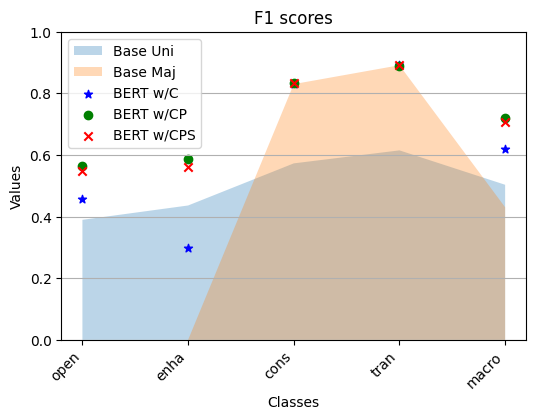

In [ ]:
plot_metric('f1')

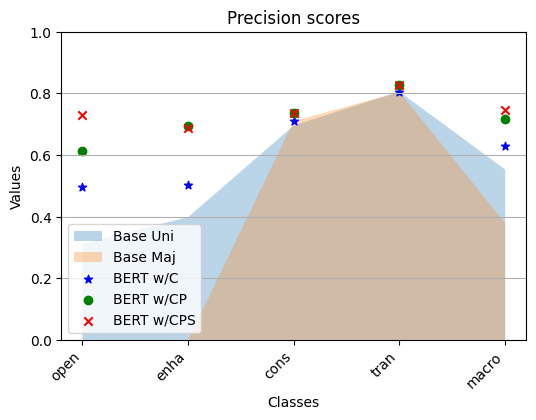

In [ ]:
plot_metric('precision')

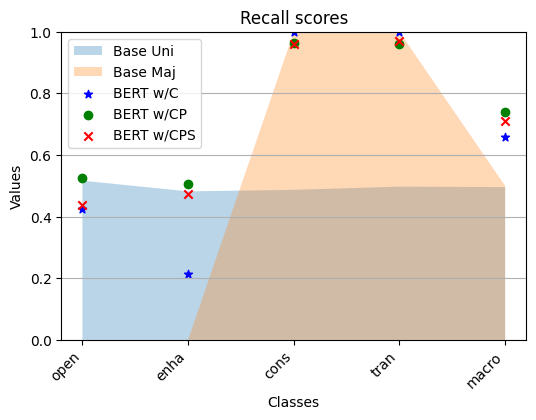

In [ ]:
plot_metric('recall')

Classification reports.

In [ ]:
print('BERT w/C')
print(report_bert_c)

BERT w/C
                    precision    recall  f1-score   support

openness_to_change       0.50      0.43      0.46       474
  self_enhancement       0.50      0.21      0.30       647
      conservation       0.71      1.00      0.83      1119
self_transcendence       0.80      1.00      0.89      1268

         micro avg       0.71      0.78      0.74      3508
         macro avg       0.63      0.66      0.62      3508
      weighted avg       0.68      0.78      0.70      3508
       samples avg       0.73      0.82      0.73      3508



In [ ]:
print('BERT w/CP')
print(report_bert_cp)

BERT w/CP
                    precision    recall  f1-score   support

openness_to_change       0.61      0.53      0.57       474
  self_enhancement       0.69      0.51      0.59       647
      conservation       0.74      0.96      0.83      1119
self_transcendence       0.83      0.96      0.89      1268

         micro avg       0.75      0.82      0.78      3508
         macro avg       0.72      0.74      0.72      3508
      weighted avg       0.74      0.82      0.77      3508
       samples avg       0.77      0.85      0.77      3508



In [ ]:
print('BERT w/CPS')
print(report_bert_cps)

BERT w/CPS
                    precision    recall  f1-score   support

openness_to_change       0.73      0.44      0.55       474
  self_enhancement       0.69      0.47      0.56       647
      conservation       0.74      0.96      0.83      1119
self_transcendence       0.83      0.97      0.89      1268

         micro avg       0.77      0.80      0.78      3508
         macro avg       0.75      0.71      0.71      3508
      weighted avg       0.76      0.80      0.77      3508
       samples avg       0.78      0.84      0.77      3508



Confusion matrices.

In [ ]:
print('BERT w/C')
print_confusion_matrix(confusion_bert_c)

BERT w/C
openness_to_change
[[897 205]
 [272 202]]
self_enhancement
[[792 137]
 [509 138]]
conservation
[[   0  457]
 [   0 1119]]
self_transcendence
[[   0  308]
 [   0 1268]]


In [ ]:
print('BERT w/CP')
print_confusion_matrix(confusion_bert_cp)

BERT w/CP
openness_to_change
[[945 157]
 [225 249]]
self_enhancement
[[785 144]
 [319 328]]
conservation
[[  71  386]
 [  42 1077]]
self_transcendence
[[  52  256]
 [  48 1220]]


In [ ]:
print('BERT w/CPS')
print_confusion_matrix(confusion_bert_cps)

BERT w/CPS
openness_to_change
[[1025   77]
 [ 266  208]]
self_enhancement
[[790 139]
 [341 306]]
conservation
[[  72  385]
 [  45 1074]]
self_transcendence
[[  50  258]
 [  39 1229]]


To interprent the confusion matrices, one must look at the main diagonal - the true negatives and true positives. The higher these numbers are, the better the performance of the model is.

We can notice that in the *openness_to_change* category, **BERT w/C** model is weaker compared to the other variants - we observe more missclassified samples. The *self_enhancement* label follows a similar pattern, as fewer examples appear in the training set w.r.t. the other categories.

As the classification report states, both *openness_to_change* and *self_enhancement* categories have a lower support compared to the others; this fact may suggest the models struggle to learn such concepts due to the lack of samples in the train dataset.

Regarding **BERT w/CP** and **BERT w/CPS**, we do not observe a clear difference as the model performances are very close to each other.

Regarding the Baselines, all the models outperform the Uniform reference when it comes to the macro F1 score. A similar behaviour is observed in each individual category. We have a particularly strong Majority Baseline especially in the *conservation* and *self-transcendence* categories, as all the BERT models equal such performances.

##🎈Task 6 - Report